In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import importlib
from tqdm.auto import tqdm
matplotlib.rcParams['figure.figsize']=5,5
from time import sleep
from IPython.display import clear_output

importlib.reload(importlib.import_module('fluid2D'))
from fluid2D import *;import fluid2D
importlib.reload(importlib.import_module('cloudModel'))
from cloudModel import *

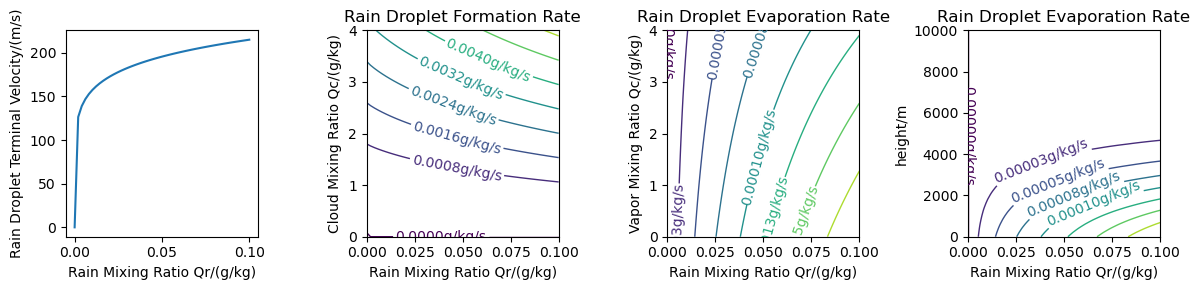

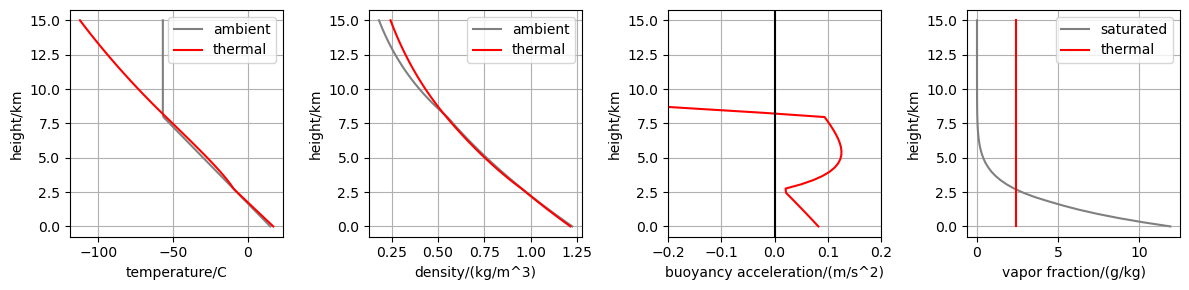

In [3]:
show_rain_models()
desc=Atmosphere_Model_Desc(L0=gravity_constant/air_heat_capacity_isobaric-.0007,T_thermal=sea_level_temperature+2,RH_thermal=.2)
heights=np.linspace(0,15000)
pbar,rhobar,Tbar=atmosphere_model(heights,desc=desc)
show_buoyancy_analysis(heights=heights,T0=desc.T_thermal,RH0=desc.RH_thermal,Tbar=Tbar,pbar=pbar)

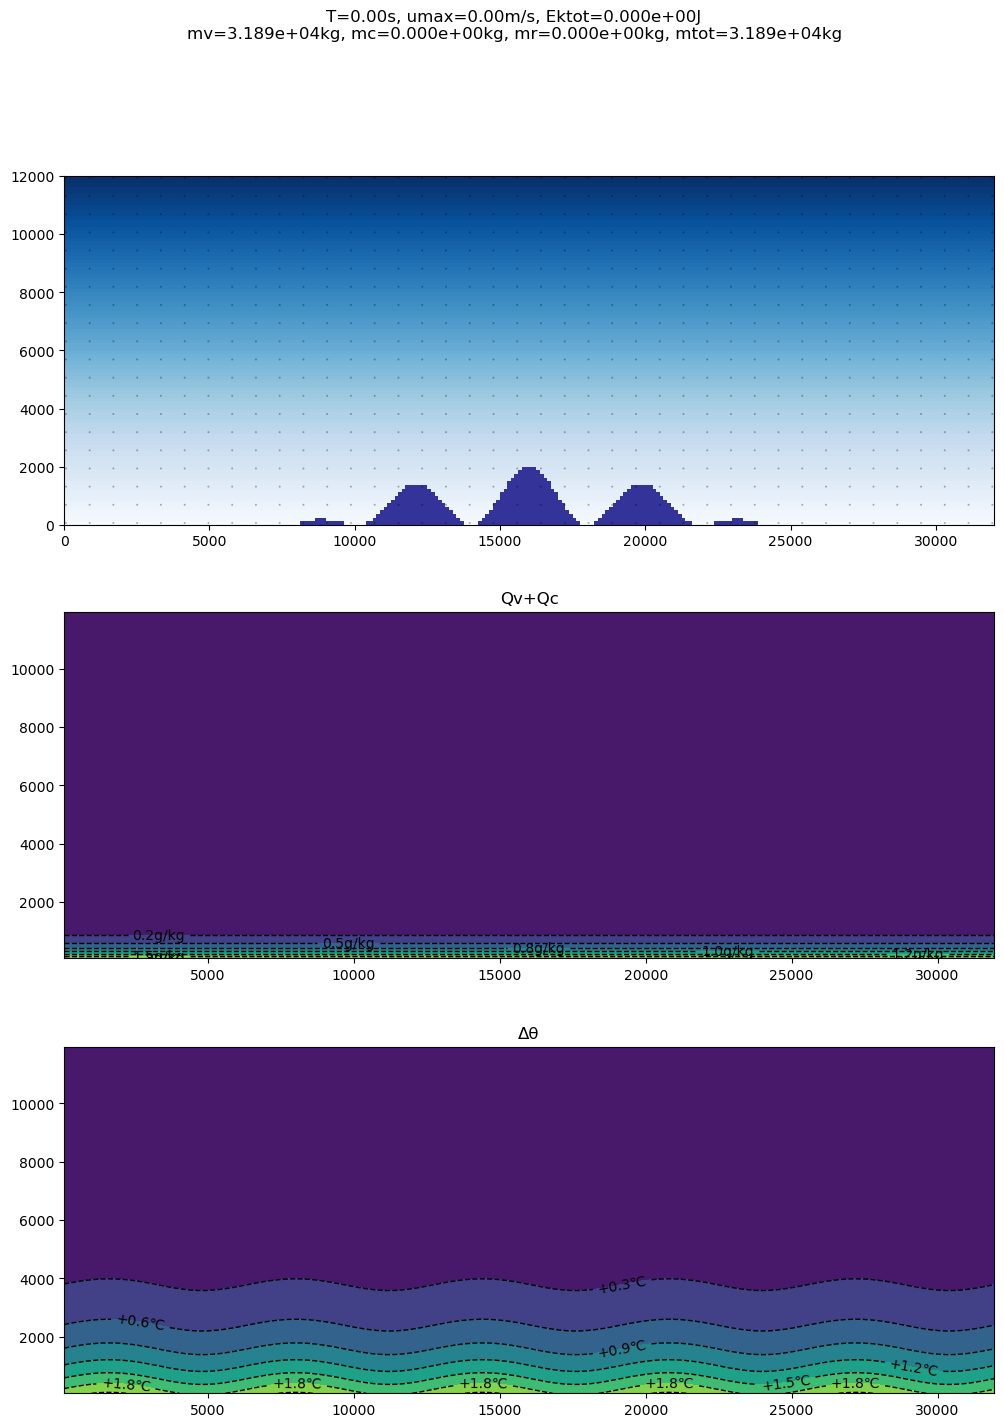

In [4]:
fluid2D.gridRes=(256,96)
fluid2D.cellSizes=(32000/fluid2D.gridRes[0],12000/fluid2D.gridRes[1])
fluid2D.timeStep=10
from fluid2D import * # e.g. timeStep

viscosity=1
diffuse_T=1
vorticity_eps=0

xy=get_positions()
x,y=xy[...,0],xy[...,1]
xyn=get_normalized_positions()
xn,yn=xyn[...,0],xyn[...,1]

mask=y>np.clip(-np.cos(xn*2*np.pi),0,1)*(.5+.5*+np.cos(8*xn*2*np.pi))*2000

pbar,rhobar,Tbar=atmosphere_model(y,desc=desc)
thetabar=get_potential_temperature(Tbar,pbar)
Qvs=get_saturated_vapor_fraction(Tbar,pbar)

time=0

u_bc=np.zeros_like(xy)
u=u_bc.copy()

theta_bc=thetabar.copy()
theta=theta_bc.copy()
theta+=(desc.T_thermal-desc.T0)*(1+.1*np.sin(xn*5*2*np.pi))*np.exp(-y/2000)
#theta+=np.where(np.logical_and(x>5000,x<7000),50,0)*np.exp(-y/2000)

_,p=solve_pressure(u,density=rhobar,nIter=40,old_pressure=None)

Qv_bc=desc.RH_thermal*Qvs*np.exp(-y/500)
Qv=Qv_bc.copy()
Qc=np.zeros_like(theta)
Qr=np.zeros_like(theta)



def draw():
    #draw scene
    img=plt.cm.Blues(y/y.max())
    img=np.where(mask[...,None],img,plt.cm.terrain(0))
    cloud_alpha=np.clip(Qc*1000/.1,0,1)[...,None]
    cloud_blend=np.clip(Qc*1000/2,0,1)[...,None]
    cloud_color=(1-cloud_blend)*np.array([1,1,1,1])+cloud_blend*np.array([0,0,0,1])
    img=(1-cloud_alpha)*img+cloud_alpha*cloud_color
    rain_alpha=np.clip(Qr*1000/.5,0,.5)[...,None]
    rain_color=np.array([.3,.4,.5,1])
    img=(1-rain_alpha)*img+rain_alpha*rain_color
    
    
    
    plt.subplot(311)
    show_quiver(xy,u,scale=300,numbers=[40,20],alpha=.3)
    show_image(img,is_rgb=True)
    
    plt.subplot(312)
    plt.title('Qv+Qc')
    show_contour(xy,(Qv+Qc)*1000,fmt=lambda x:f'{x:.1f}g/kg')
    #show_quiver(xy,Qr[...,None]*ur,scale=.05,numbers=[40,20],alpha=1)
    
    plt.subplot(313)
    plt.title('Δθ')
    show_contour(xy,theta-thetabar,fmt=lambda x:f'{x:+.1f}℃')
    
    #captions
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    umax=np.max(u,axis=None)
    mv,mc,mr=calc_total_water(Qv=Qv,Qc=Qc,Qr=Qr,rhobar=rhobar,cellVolumes=np.prod(cellSizes))
    Ek=calc_total_kinematic_energy(u,rhobar)
    plt.suptitle(f'T={time:.2f}s, umax={umax:.2f}m/s, Ektot={Ek:.3e}J\n'+
                 f'mv={mv:.3e}kg, mc={mc:.3e}kg, mr={mr:.3e}kg, mtot={mv+mc+mr:.3e}kg')
    
plt.figure(figsize=(12,16))
draw()
plt.show()

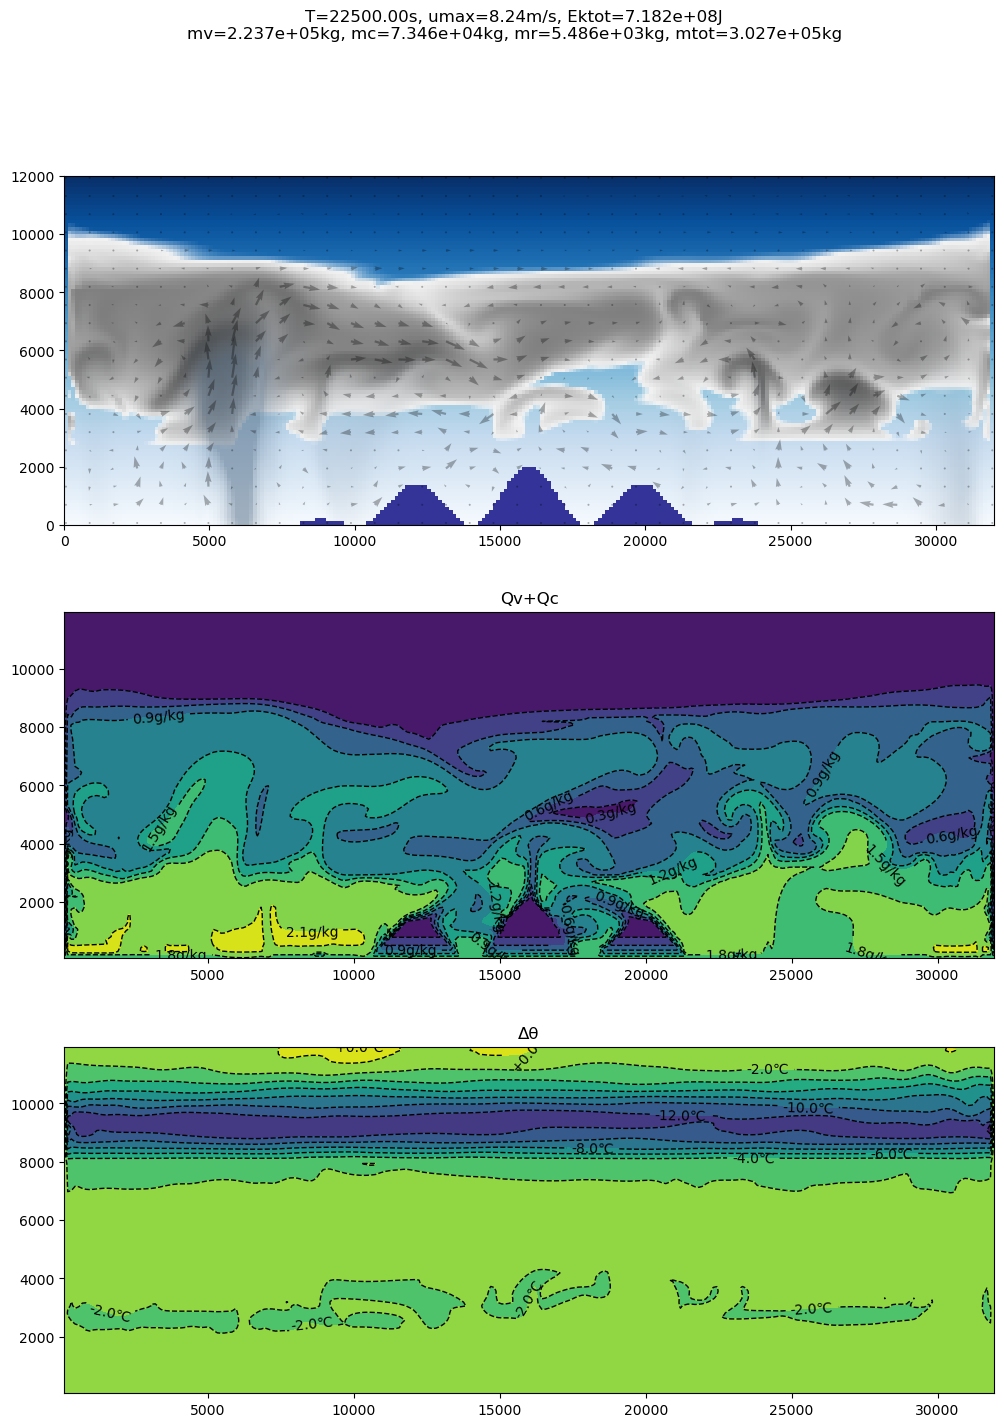

In [6]:
def update_graph():
    clear_output(wait=True)
    plt.figure(figsize=(12,16))
    draw()
    plt.show()
    sleep(0.01)


try:
    for _iter in range(int(4*3600/timeStep)):
        if _iter%30==0:
            update_graph()
        
        ur=u.copy()
        ur[...,1]=ur[...,1]-rain_droplet_terminal_velocity
        
        theta=advect(theta,u)
        Qv=advect(Qv,u)
        Qc=advect(Qc,u)
        Qr=advect(Qr,ur)
        u=advect_velocity_MacCormack(u)
        
        B=get_buoyancy_acceleration(T_ratio=theta/thetabar,Qv=Qv,Qc=Qc,Qr=Qr)
        u=add_buoyancy(u,acceleration=B)

        theta=diffuse(theta,amount=diffuse_T*timeStep,nIter=5)
        u=diffuse(u,amount=viscosity*timeStep,nIter=5)
        
        theta,Qv,Qc,Qr=update_cloud_model(theta,Qv,Qc,Qr,pbar=pbar,timeStep=timeStep)

        u,w=amplify_vorticity(u,vorticity_eps)

        u,p=solve_pressure(u,density=rhobar,nIter=10,old_pressure=p)
        
        def apply_boundary_(x,x_bc):
            shape=x.shape
            x=x.reshape(shape[:2]+(-1,))
            x_bc=x_bc.reshape(shape[:2]+(-1,))
            x=np.where(mask[...,None],x,x_bc)
            return apply_dirichlet_boundary_(x,x_bc).reshape(shape)
        
        u=apply_boundary_(u,u_bc)
        theta=apply_boundary_(theta,theta_bc)
        Qv=apply_boundary_(Qv,Qv_bc)
        #Qr=apply_boundary_(Qr,Qr_bc)
        
        time=time+timeStep
        
except KeyboardInterrupt:
    pass
